# Comparing different point interpolation approaches.

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

from metpy.mapping import MPMap
from metpy.mapping.tests.test_MPGridding import station_test_data

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 16)

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

levels = list(range(-30, 30, 1))
cmap = plt.get_cmap('jet')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

x, y, temp = station_test_data("air_temperature", from_proj, to_proj)

x = x[~np.isnan(temp)]
y = y[~np.isnan(temp)]
temp = temp[~np.isnan(temp)]

# Nearest neighbor interpolation

http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.NearestNDInterpolator.html#scipy.interpolate.NearestNDInterpolator

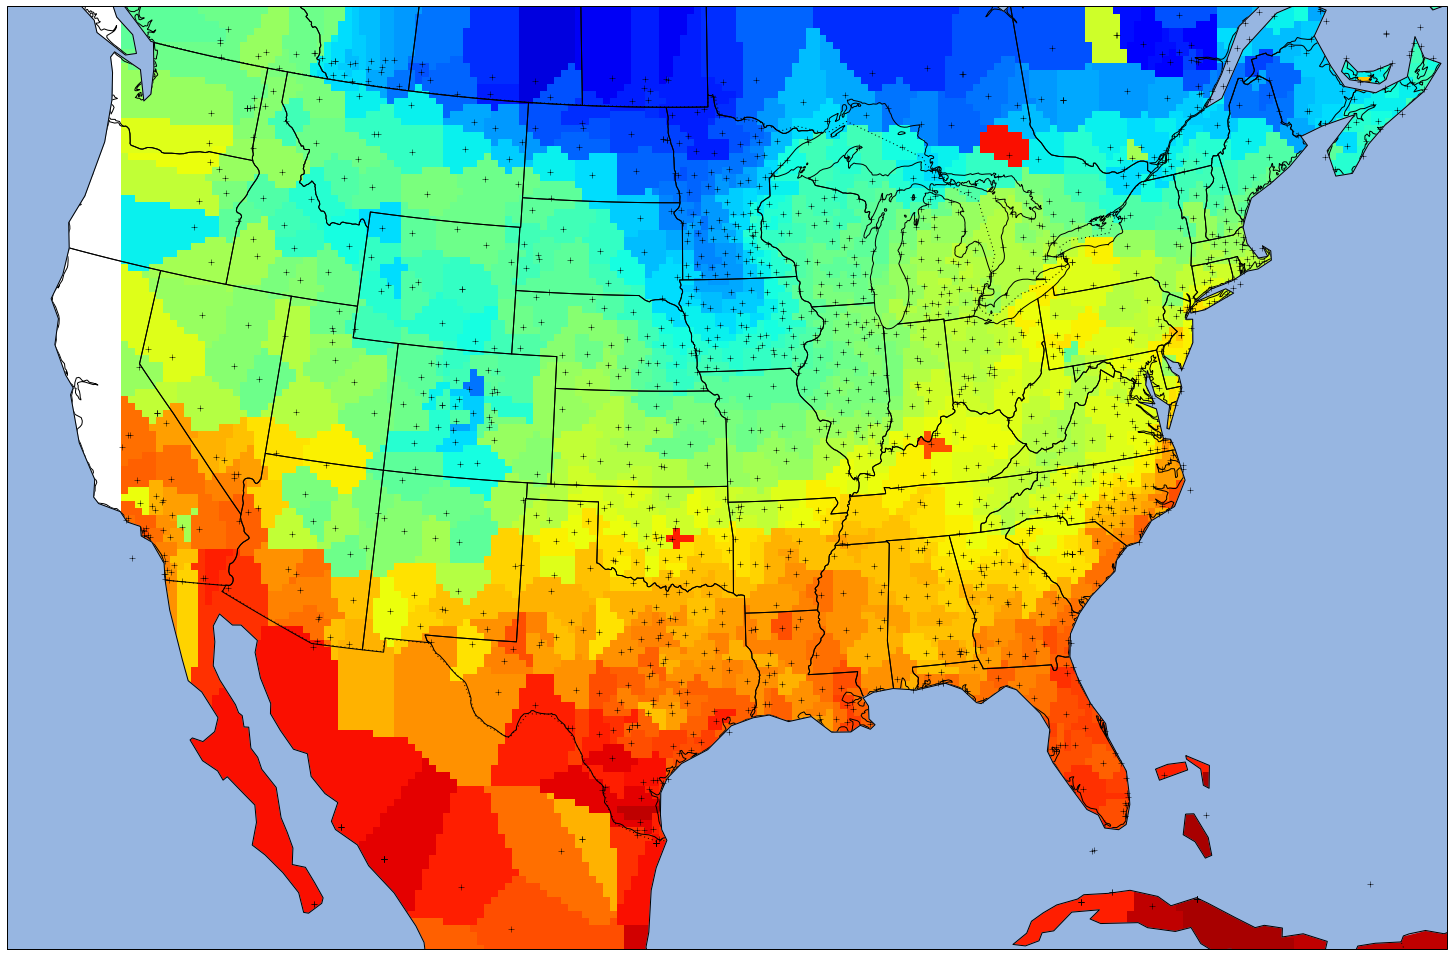

In [2]:
gx, gy, img = interp_points(x, y, temp, interp_type='nearest', xres=25000, yres=25000)

view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

view.plot(x, y, "k+")
mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)

# Linear interpolation

http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator

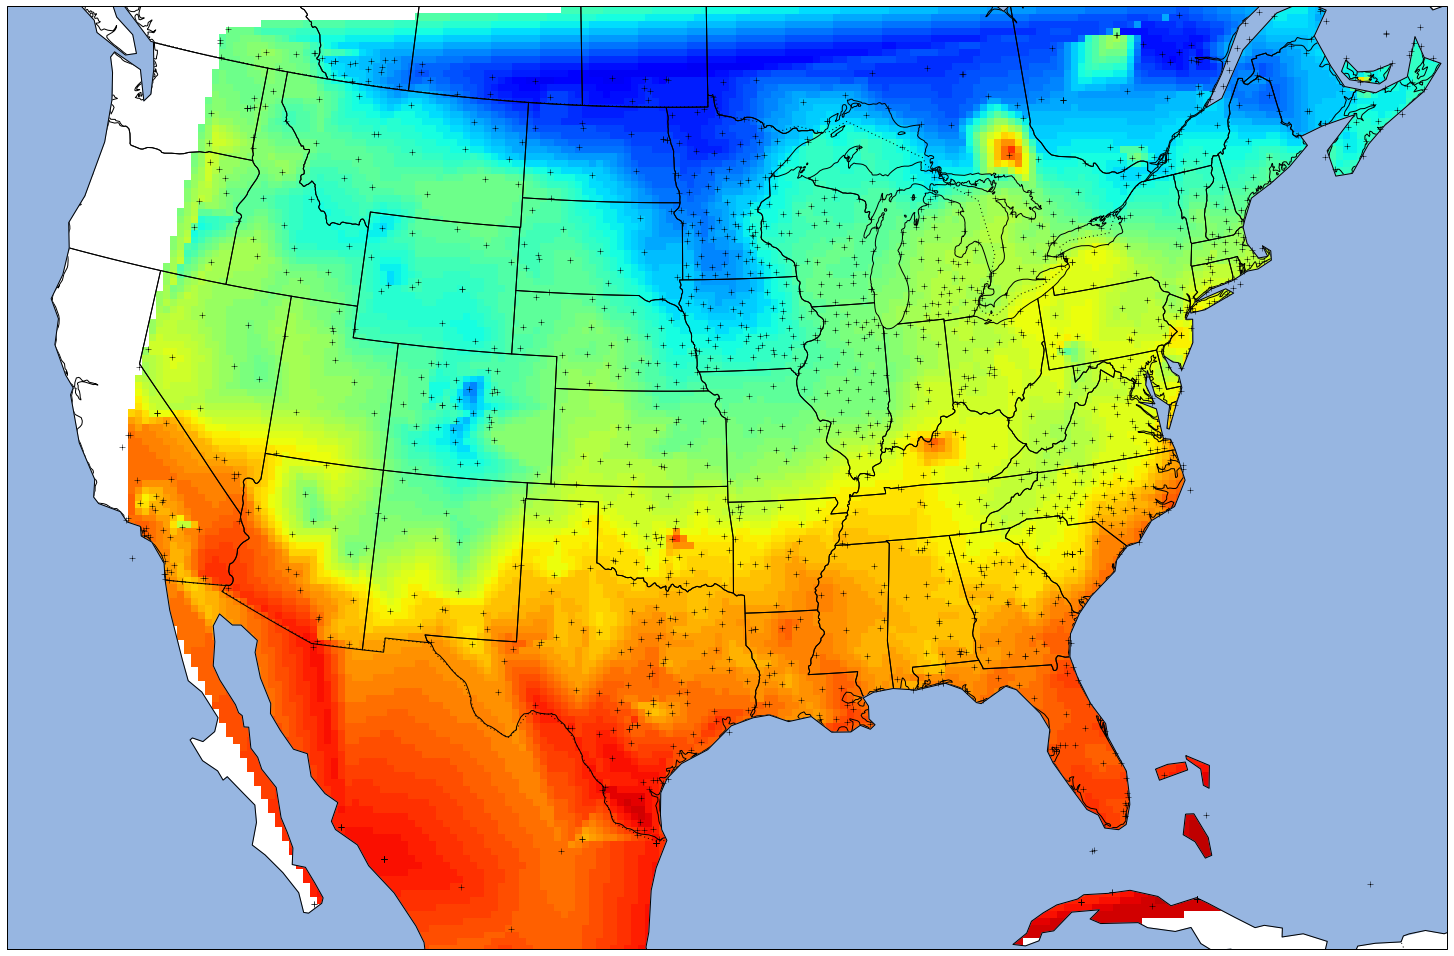

In [3]:
gx, gy, img = interp_points(x, y, temp, interp_type='linear', xres=25000, yres=25000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')
view.plot(x, y, "k+")
mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)

# Cubic interpolation

http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html#scipy.interpolate.CloughTocher2DInterpolator

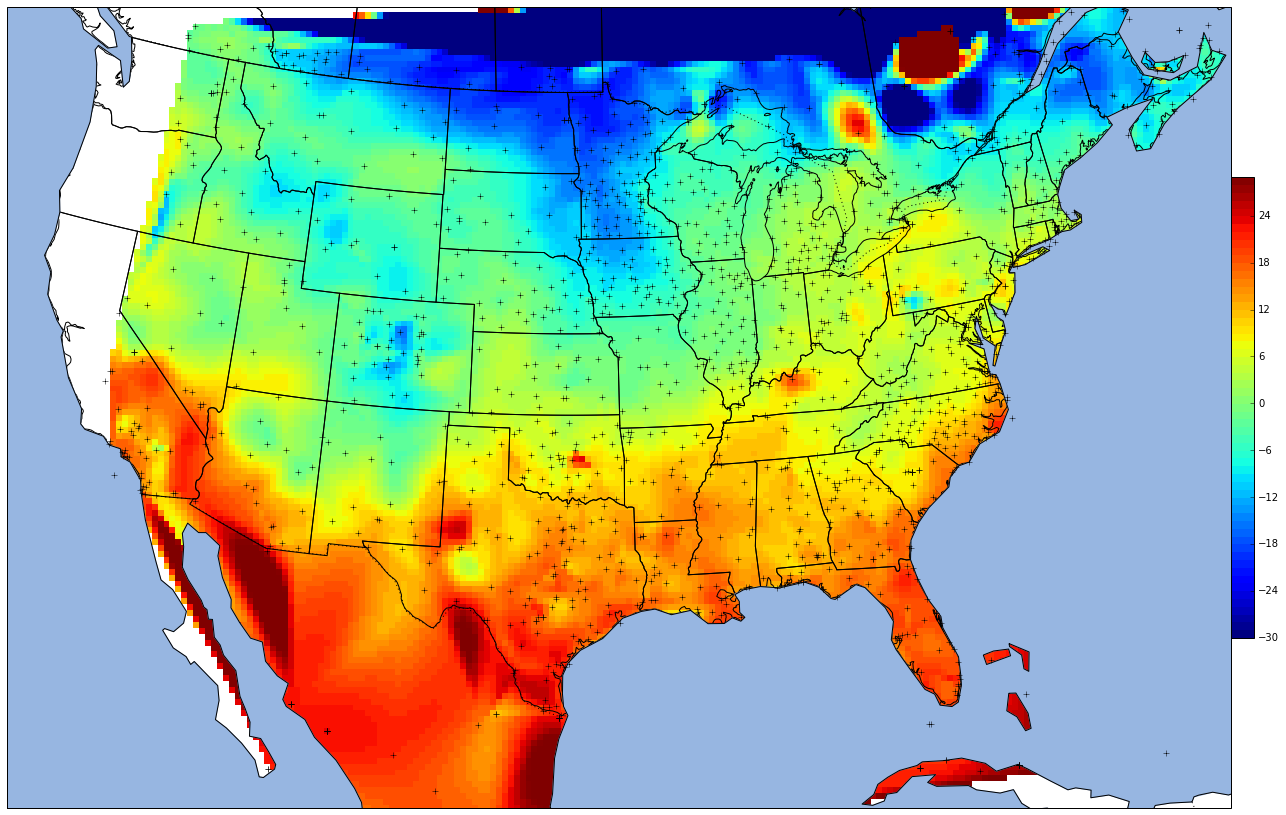

In [4]:
gx, gy, img = interp_points(x, y, temp, interp_type='cubic', xres=25000, yres=25000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')
view.plot(x, y, "k+")
mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Natural neighbor (ncar natgrid implementation)

https://github.com/matplotlib/natgrid

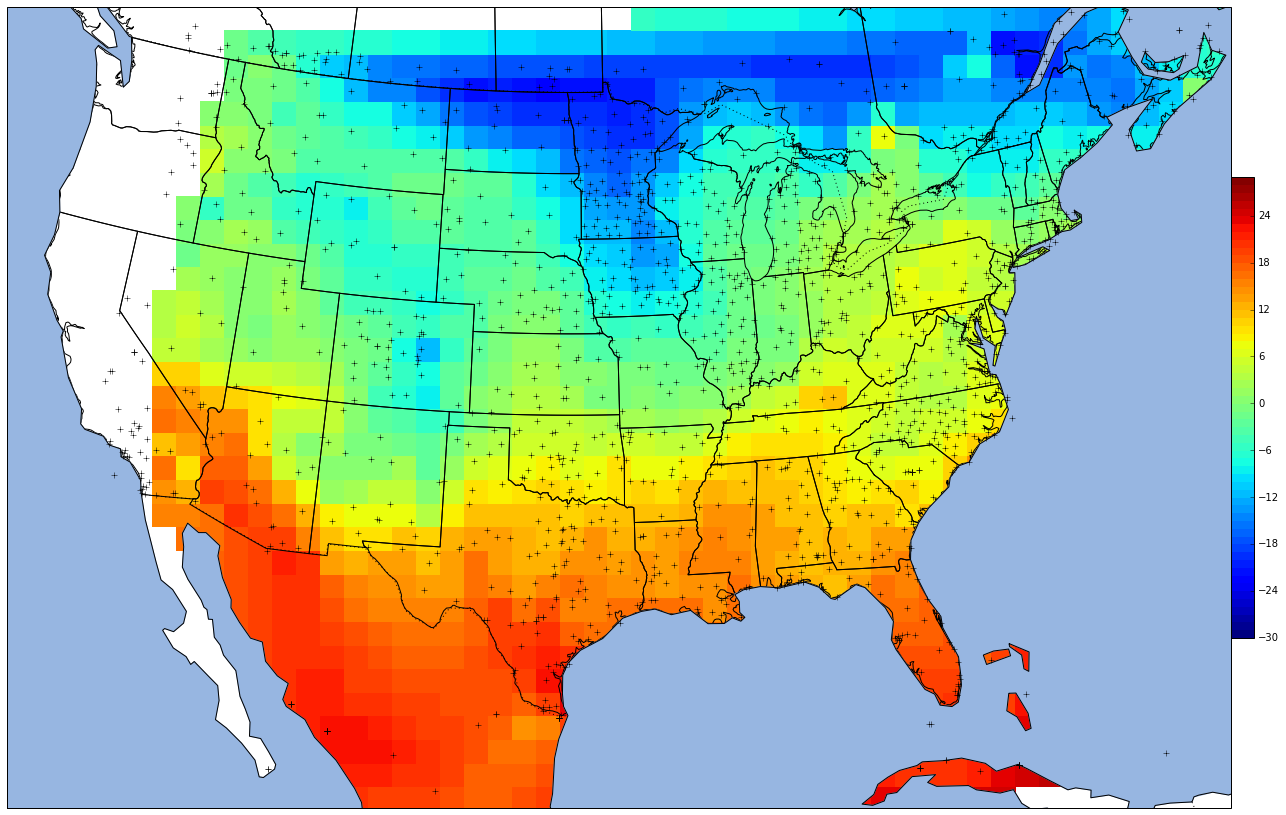

In [3]:
gx, gy, nngrid_img = MPMap.interp_points(x, y, temp, interp_type='nngrid', xres=100000, yres=100000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')
view.plot(x, y, "k+")
mmb = view.pcolormesh(gx, gy, nngrid_img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Natural neighbor interpolation (MetPy implementation)

https://github.com/metpy/MetPy/files/138653/cwp-657.pdf

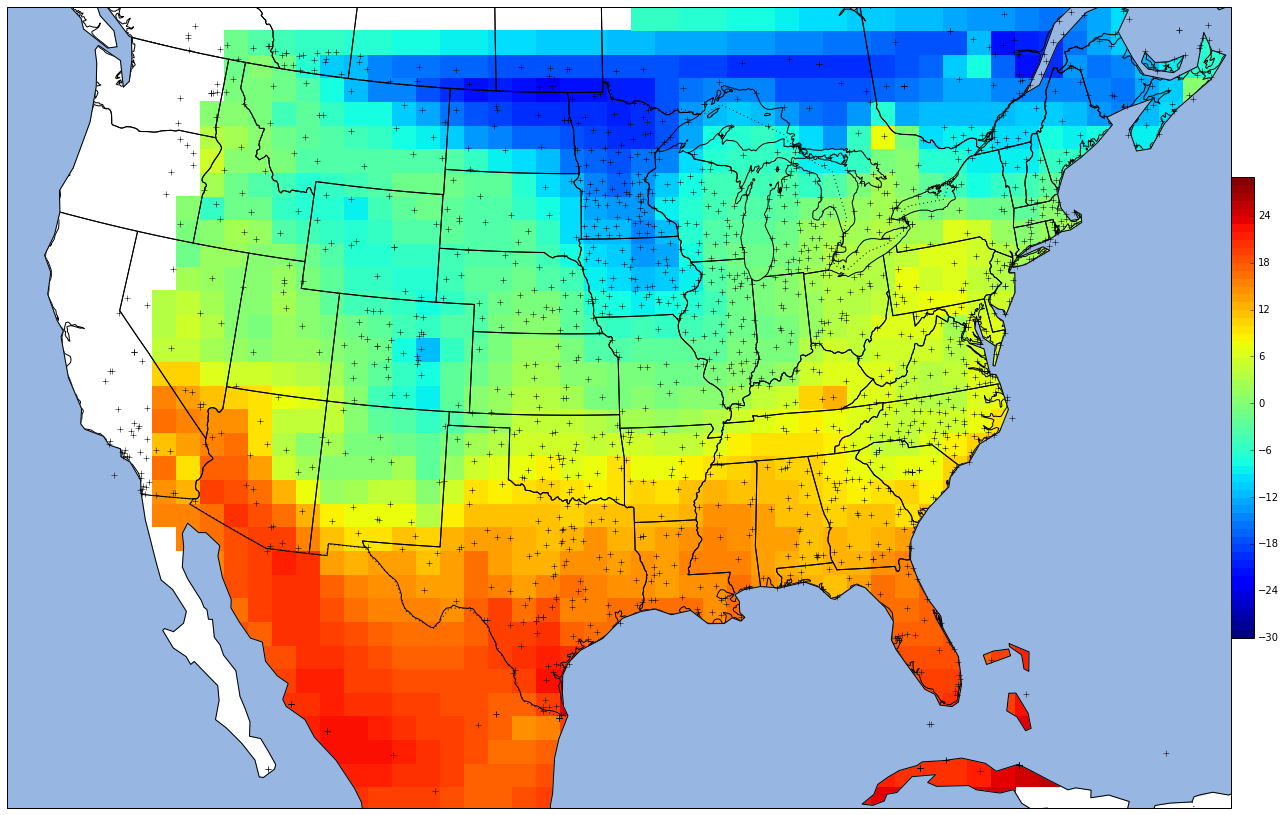

In [2]:
gx, gy, img = MPMap.interp_points(x, y, temp, interp_type='natural_neighbor', xres=100000, yres=100000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')
view.plot(x, y, "k+")
mmb = view.pcolormesh(gx, gy, img.reshape(gx.shape), cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Difference between metpy and natgrid

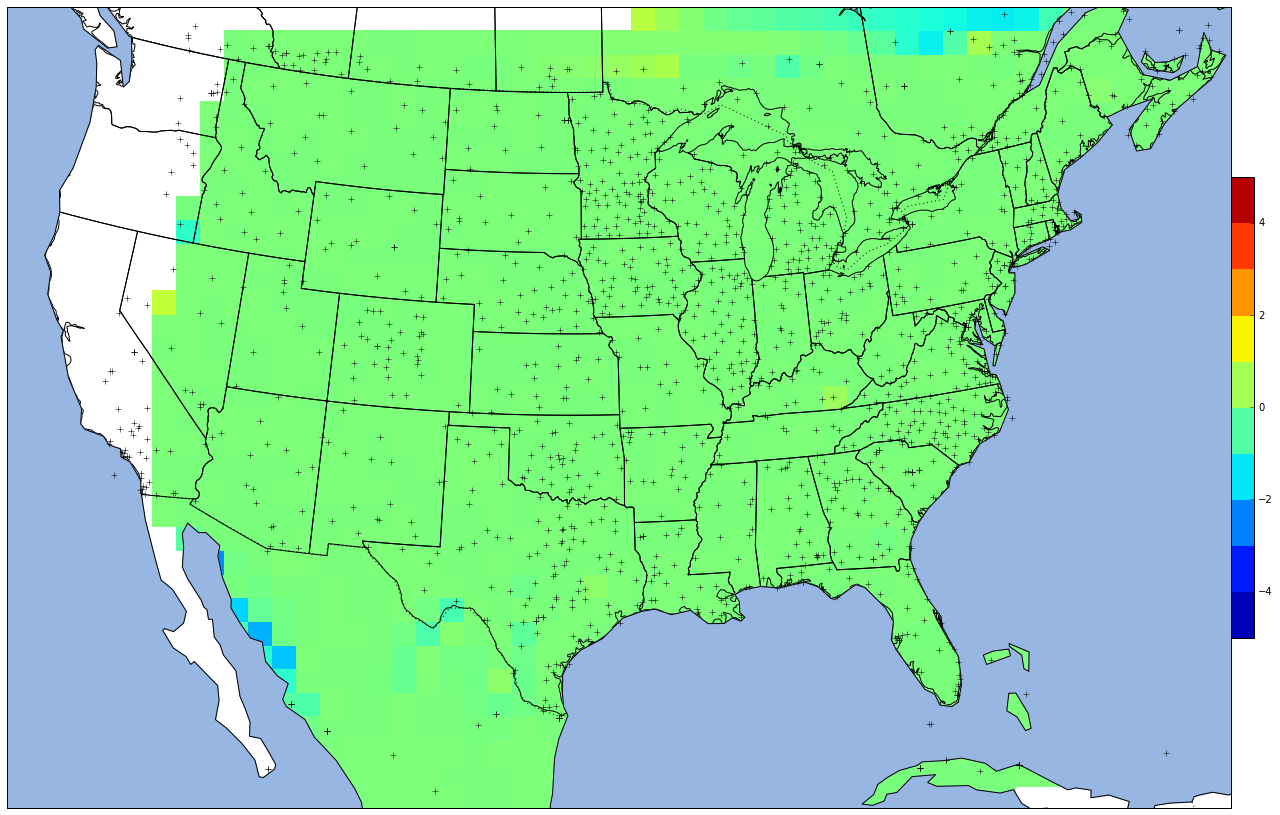

In [4]:
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')
view.plot(x, y, "k+")
mmb = view.pcolormesh(gx, gy, img.reshape(gx.shape)-nngrid_img, vmin=-5, vmax=5)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=list(range(-5,6)))